In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

import sys
sys.path.append("../src")
from model import MyModel

In [2]:
def u0(x):
    """initial condition"""
    u = -torch.sin(torch.pi * x)
    return u

# Create a model

Create a model for
$$
u_t + u u_x = mu * u_{xx}
$$
with $u(x,0)=-sin(\pi x)$ and $u(-1,t)=u(1,t)=0$.

In [3]:
# 1. FIXME -- training data
boundary_condition_points = [torch.tensor([-1, t]) for t in torch.linspace(0, 1, 500)]
boundary_condition_points.extend([torch.tensor([1, t]) for t in torch.linspace(0, 1, 500)])
boundary_condition_points = torch.stack(boundary_condition_points, dim = 0)

initial_condition_points = [torch.tensor([x, 0]) for x in torch.linspace(-1, 1, 500)]
initial_condition_points = torch.stack(initial_condition_points, dim = 0)

residual_points = [torch.tensor([x,t], requires_grad = True) for x in torch.linspace(-1 + 0.001, 1 - 0.001, 100) 
                                                             for t in torch.linspace(0 + 0.001, 1 - 0.001, 100)]

residual_points = torch.stack(residual_points, dim = 0)

# 2. set the model
torch.manual_seed(23939)
model = MyModel(2, [15, 15, 15], ['tanh', 'tanh', 'tanh'], 1)
print(model)
# 3. set the optimizer
lr = 0.008
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 13000

loss_history = []
mu = .01 / np.pi

# 4. FIXME -- set the loss for BC, IC, and the residual
def loss_function(model, bcps, icps, rps): 
    
    # Boundary conditions loss
    bcp_xs = bcps[:,0].reshape(-1, 1)
    bcp_ts = bcps[:,1].reshape(-1, 1)
    boundary_values = model(torch.cat([bcp_xs, bcp_ts], dim=1))
    boundary_loss = torch.mean(torch.square(boundary_values))
    
    # Initial condition loss
    icp_xs = icps[:,0].reshape(-1, 1)
    icp_ts = icps[:,1].reshape(-1, 1)
    initial_values = model(torch.cat([icp_xs, icp_ts], dim=1))
    initial_ground_truth = u0(icp_xs)
    initial_loss = torch.nn.MSELoss()(initial_values, initial_ground_truth)
    
    # Residual loss using derivatives (the interesting part)
    residual_pts_xs = residual_points[:,0].reshape(-1, 1)
    residual_pts_ts = residual_points[:,1].reshape(-1, 1)
    output_on_residual_points = model(torch.cat([residual_pts_xs, residual_pts_ts], dim=1))
    

    
    grad_t = torch.autograd.grad(outputs=output_on_residual_points,
                                  inputs=residual_pts_ts, 
                                  grad_outputs=torch.ones_like(residual_pts_ts, requires_grad=False), 
                                  retain_graph=True, 
                                  create_graph=True)[0]
    
    grad_x = torch.autograd.grad(outputs=output_on_residual_points,
                              inputs=residual_pts_xs,
                              grad_outputs=torch.ones_like(residual_pts_xs, requires_grad=False),
                              retain_graph=True,
                              create_graph=True)[0]

    grad_xx = torch.autograd.grad(outputs = grad_x, 
                                  inputs = residual_pts_xs, 
                                  grad_outputs=torch.ones_like(residual_pts_xs, requires_grad=False),
                                  retain_graph=True, 
                                  create_graph=True)[0]
    
#     f = grad_t + output_on_residual_points * grad_x - mu * grad_xx 
#     residual_loss = torch.mean(torch.square(f))
    
    lhs = grad_t + output_on_residual_points * grad_x
    rhs = mu * grad_xx
#     print(lhs.shape)
#     print(rhs.shape)
    residual_loss = torch.nn.MSELoss()(lhs, rhs)
    
    
    loss_value = boundary_loss + initial_loss + residual_loss
    
    return loss_value

MyModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): Tanh()
    (6): Linear(in_features=15, out_features=1, bias=True)
  )
)


In [4]:
n_epochs = 1300
for i in range(n_epochs):

    opt.zero_grad()
    
    loss = loss_function(model, boundary_condition_points, initial_condition_points, residual_points)
    loss_history.append(loss.item())
    
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f'epoch {i}, loss = {loss}')

epoch 0, loss = 0.6445722579956055
epoch 100, loss = 0.1550687998533249
epoch 200, loss = 0.1296081393957138
epoch 300, loss = 0.09786780178546906
epoch 400, loss = 0.09153810888528824
epoch 500, loss = 0.08558361977338791
epoch 600, loss = 0.07792671024799347
epoch 700, loss = 0.07239337265491486
epoch 800, loss = 0.0638599544763565
epoch 900, loss = 0.06367076933383942
epoch 1000, loss = 0.05072113499045372
epoch 1100, loss = 0.05281512439250946
epoch 1200, loss = 0.04501475393772125


In [5]:
final_loss = loss_function(model, boundary_condition_points, initial_condition_points, residual_points)
print(final_loss)

tensor(0.0319, grad_fn=<AddBackward0>)


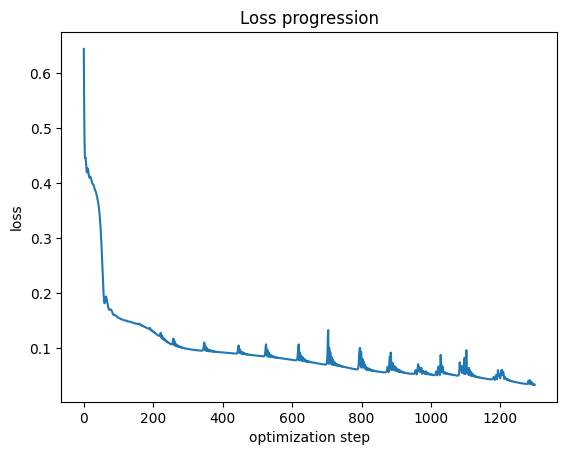

In [6]:
plt.plot(loss_history)
plt.title("Loss progression")
plt.xlabel('optimization step')
plt.ylabel('loss');
plt.show()

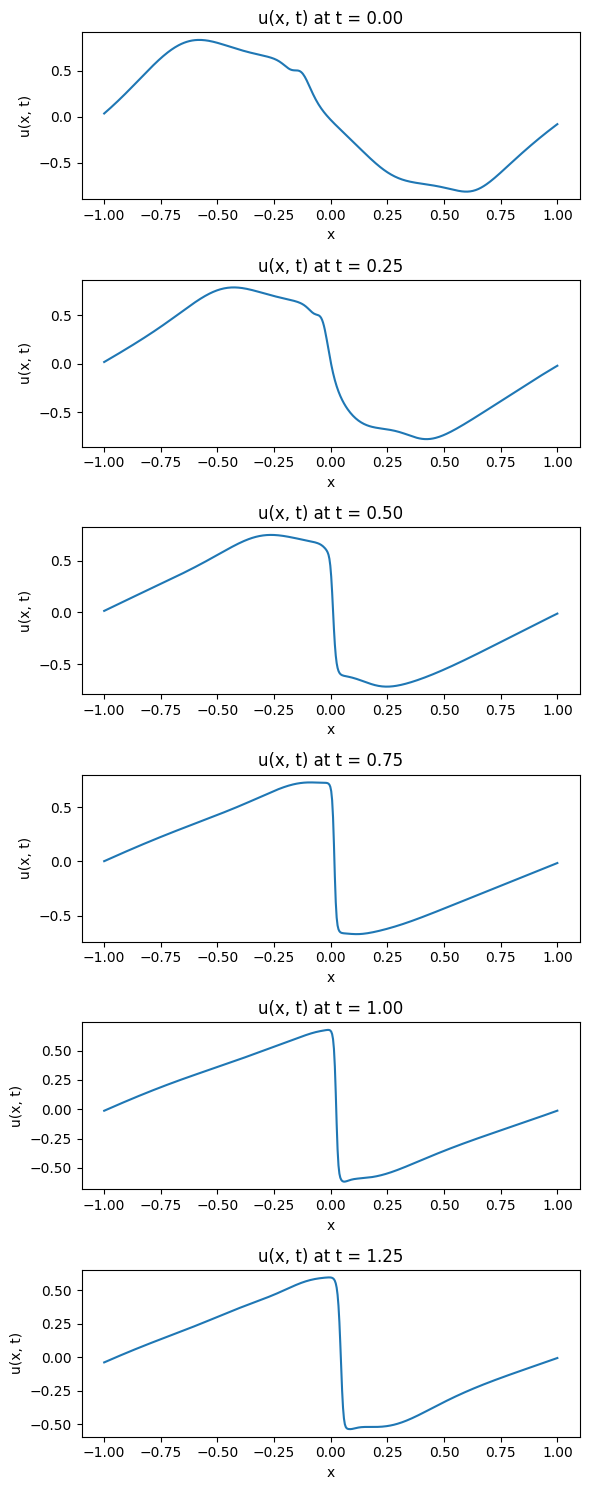

In [7]:
fig, axs = plt.subplots(6, figsize=(6,15))
for i in range(6):
    icp_xs = initial_condition_points[:,0].reshape(-1, 1)
    ts = torch.ones_like(icp_xs) * i * 0.25
    f = model(torch.cat([icp_xs, ts], dim=1)).detach().numpy()
    axs[i].plot(icp_xs.detach().numpy(), f, label='PINN')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('u(x, t)')
    axs[i].set_title('u(x, t) at t = {:.2f}'.format(i * 0.25))

plt.tight_layout()
plt.show()

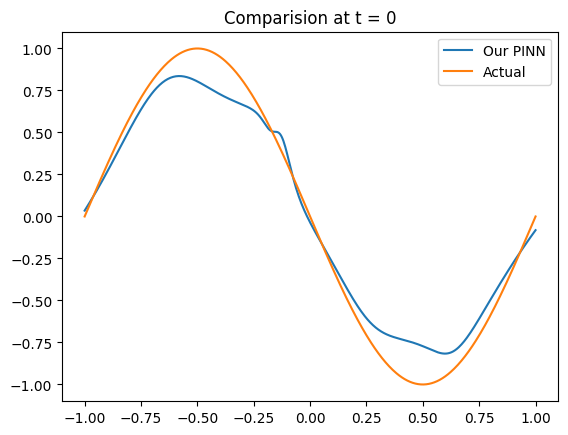

In [8]:
icp_xs = initial_condition_points[:,0].reshape(-1, 1)
icp_ts = initial_condition_points[:,1].reshape(-1, 1)
initial_values = model(torch.cat([icp_xs, icp_ts], dim=1))
plt.plot(icp_xs.detach().numpy(), model(torch.cat([icp_xs, icp_ts], dim=1)).detach().numpy(), label='Our PINN')
plt.plot(icp_xs.detach().numpy(), u0(icp_xs).detach().numpy(), label='Actual')
plt.legend()
plt.title("Comparision at t = 0")
plt.show()

/opt/homebrew/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


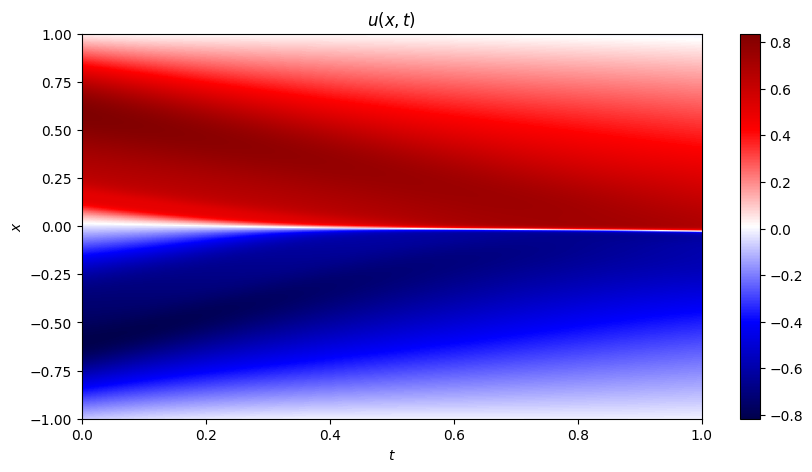

In [9]:
plt.figure(figsize = (10, 5))
n = 1000
xs, ts = torch.meshgrid(torch.linspace(-1.0, 1, n), torch.linspace(0.0, 1.0, n))
xs = xs.reshape(-1, 1).requires_grad_(False)
ts = ts.reshape(-1, 1).requires_grad_(False)
f = model(torch.cat([xs, ts], dim=1)).reshape((n ,n))
heatmap = plt.imshow(f.detach().numpy(), extent=[0,1,-1,1], cmap='seismic', interpolation='nearest', aspect='auto')
plt.colorbar(heatmap)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title(r'$u(x,t)$')
plt.show()

In [10]:
torch.save(model, "../trained_models/pinn-burgers-vis.pt")

In [92]:
def visualize_residual_error(model_name, inpx_range=(-1.0, 1.0), inpt_range=(0.0, 1.0)):
    model = torch.load(model_name)
    
    plt.figure(figsize = (10, 5))
    n = 2000
    xs, ts = torch.meshgrid(torch.linspace(inpx_range[0], inpx_range[1], n), 
                            torch.linspace(inpt_range[0], inpt_range[1], n))
    xs = xs.reshape(-1, 1).requires_grad_(True)
    ts = ts.reshape(-1, 1).requires_grad_(True)
    f = model(torch.cat([xs, ts], dim=1))
    grad_t = torch.autograd.grad(outputs=f,
                                  inputs=ts, 
                                  grad_outputs=torch.ones_like(ts, requires_grad=False), 
                                  retain_graph=True, 
                                  create_graph=True)[0]
    
    grad_x = torch.autograd.grad(outputs=f,
                              inputs=xs,
                              grad_outputs=torch.ones_like(xs, requires_grad=False),
                              retain_graph=True,
                              create_graph=True)[0]
    
    grad_xx = torch.autograd.grad(outputs = grad_x.sum(), 
                              inputs = xs, 
                              retain_graph=True, 
                              create_graph=True)[0]
    
    
    residual_err = (grad_t + f * grad_x - mu * grad_xx).reshape(n,n)
    
    print("Min:", residual_err.min())
    print("Max:", residual_err.max())
    print("Mean:", residual_err.mean())
    
    heatmap = plt.imshow(residual_err.detach().numpy(), extent=[0,2,-1,1], cmap='seismic', interpolation='nearest', aspect='auto')
    plt.colorbar(heatmap)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.title(r'$u_t + u * u_x$')
    plt.show()

Min: tensor(-0.3146, grad_fn=<MinBackward1>)
Max: tensor(0.2074, grad_fn=<MaxBackward1>)
Mean: tensor(-0.0305, grad_fn=<MeanBackward0>)


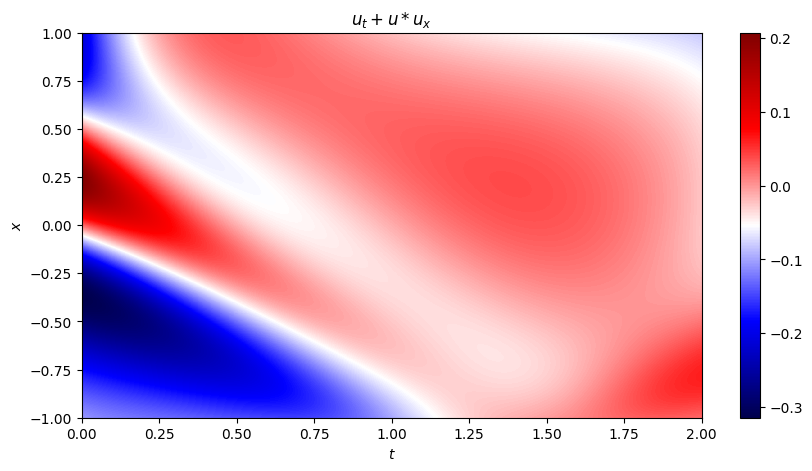

In [95]:
visualize_residual_error("../trained_models/pinn-burgers-vis.pt", inpx_range=(-1,-0.25))

Min: tensor(-2.3169, grad_fn=<MinBackward1>)
Max: tensor(1.0610, grad_fn=<MaxBackward1>)
Mean: tensor(-0.1930, grad_fn=<MeanBackward0>)


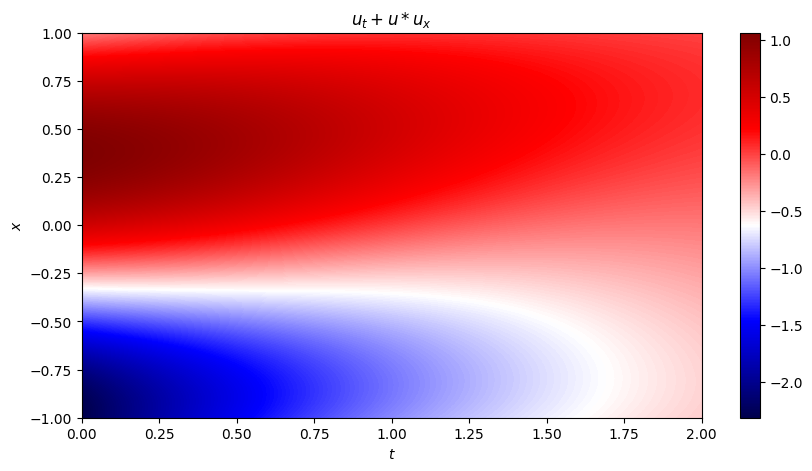

In [96]:
visualize_residual_error("../trained_models/pinn-burgers_weak.pt", inpx_range=(-1,-0.25))